## Import necessary libraries

In [8]:
import os
import shutil
import imghdr
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import transform, io, color
from skimage.util import crop
from skimage.color import rgba2rgb
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, ensemble
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import sklearn.neural_network as snn
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from skimage.util import crop
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from skimage.filters import sobel
from sklearn.decomposition import PCA


## 1.0 Create pipeline to load dataset

### 1.1 

In [2]:
# Working with the Fruits dataset
dataset = 'Vegetables'

## groups
groups = ['train','test', 'val']

In [3]:
# Function to flatten nested image folders 
def flattenDirectory(file):   
    for o in file:
        base = os.path.join(o,dataset)
        for x in os.listdir(base):
            for y in os.listdir(os.path.join(base,x)):
                if (os.path.isdir(os.path.join(base,x,y))):
                    for z in os.listdir(os.path.join(base,x,y)):
                        if (not(os.path.isdir(os.path.join(base,x,y,z)))):
                            shutil.move(os.path.join(base,x,y,z), os.path.join(base,x))
                else:
                    pass

            # Remove empty lower category folders
            for i in os.listdir(os.path.join(base,x)):
                if (os.path.isdir(os.path.join(base,x,i))):
                    
                    dir = os.listdir(os.path.join(base,x,i))
                    if (len(dir) < 1):
                        os.removedirs(os.path.join(base,x,i))
                        
flattenDirectory(groups)

In [4]:
# Function to check for and remove unwanted file types
valid_extensions = ['jpeg', 'jpg', 'png']

def removeUnwantedImages(file):
    for i in file:
        base = os.path.join(i,dataset)
        for j in os.listdir(base):
            for k in os.listdir(os.path.join(base,j)):
                image_extension = imghdr.what(os.path.join(base,j,k))
                if image_extension not in valid_extensions:
                    os.remove(os.path.join(base,j,k))
                    
removeUnwantedImages(groups)

In [5]:
# Create a list of all the classes. Take train dataset as a sample

sample_data = 'train'
sample_path = os.path.join(sample_data,dataset)
class_list = []
for i in os.listdir(sample_path):
    class_list.append(i)

In [6]:
def load_dataset(folders):
    data = []
    for folder in folders:
        images = []
        labels = []
        image_size = 200

        fruit_type_list = os.listdir(os.path.join(folder,dataset))
        
        # Iterate through the list of fruits
        for fruit_type in fruit_type_list:
            current_fruit_list = os.listdir(os.path.join(folder,dataset,fruit_type))

            for image_file in current_fruit_list:
                path_image = os.path.join(folder,dataset,fruit_type,image_file)

                # Read image
                image = io.imread(path_image)
                
                # Resize image 
                image = transform.resize(image, (image_size,image_size))
                
                # Get the index of the fruit type
                label = class_list.index(fruit_type)

                images.append(image)
                labels.append(label)
                
        # Convert to numpy array 
        images = np.array(images)
        labels = np.array(labels)

        data.append((images,labels))

        print(folder,'dataset added')
    return data


In [7]:
folders = ['train','test']
data = load_dataset(folders)

train dataset added
test dataset added


## 2. Image Preprocessing

### 2.0 Split dataset

In [9]:
# Split dataset
((X_train, y_train),(X_test, y_test)) = data

In [10]:
# Length of images in both train and test
X_train.shape,X_test.shape

((243, 200, 200, 3), (231, 200, 200, 3))

### 2.1. Shuffle dataset

In [11]:
## shuffle dataset

X_train,y_train = shuffle(X_train,y_train, random_state=42)
X_test,y_test = shuffle(X_test,y_test, random_state=42)

In [12]:
X_test.shape

(231, 200, 200, 3)

### 2.2. Visualize images

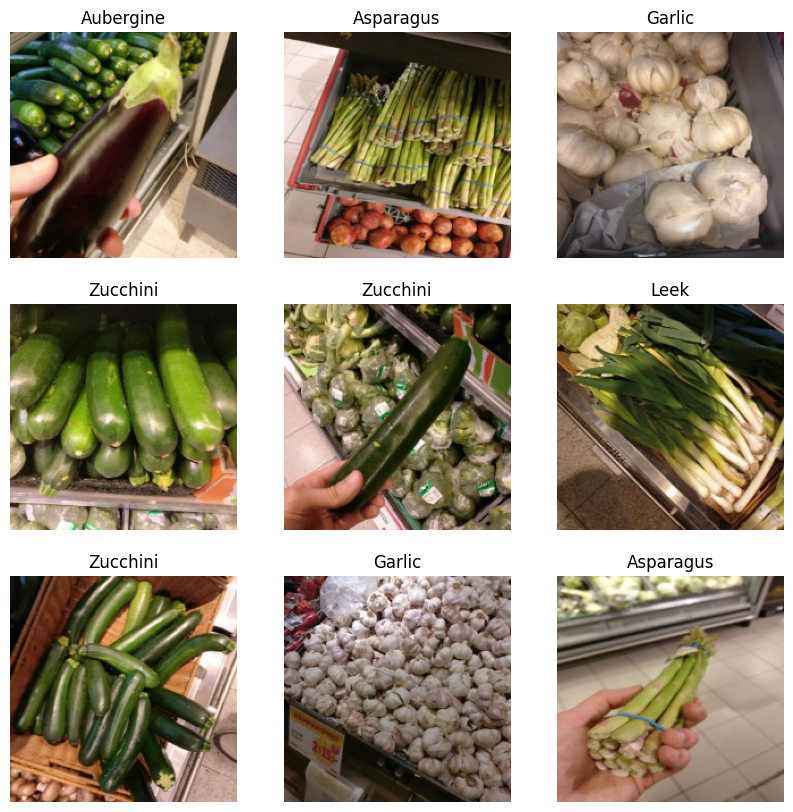

In [15]:
# Visualize data
#train_data = (X_train,y_train)
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].astype('float'))
    
    plt.title(class_list[y_train[i]])
    plt.axis("off")

### 2.3. Create function to crop images

In [16]:
# function to crop images

target_dimension = 120
dimensions = (30, 50), (30, 50), (0,0)

def crop_images(dataset):
    width = dataset.shape
    cropped_images = []
    
    if width[1] != target_dimension:
        for image in dataset:
            cropped_image = crop(image, (dimensions), copy=False)
            cropped_images.append(cropped_image)
        return np.array(cropped_images, dtype='float32')
    else:
        return dataset


In [17]:
# crop images
X_train =crop_images(X_train)
X_test = crop_images(X_test)

In [18]:
X_test.shape

(231, 120, 120, 3)

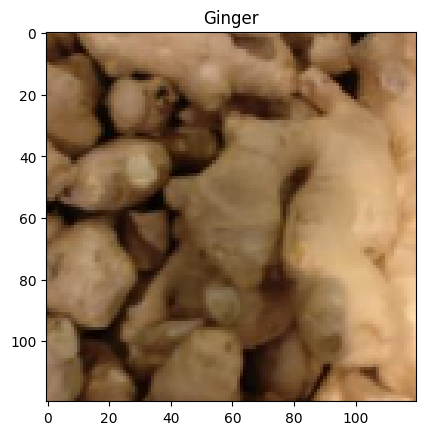

In [19]:
# visualize a cropped image
index = 56
cropped_train = plt.imshow(X_train[index])
plt.title(class_list[y_train[index]])
plt.show(cropped_train)

### 2.4. Image Normalization

In [13]:
# normalize data
scaled_train = X_train/255.0
scaled_test = X_test/255.0

In [14]:
scaled_train.shape

(243, 200, 200, 3)

## 2.5. Convert images to grayscale

In [15]:
X_trainGray = color.rgb2gray(scaled_train)
X_testGray = color.rgb2gray(scaled_test)

In [16]:
X_trainGray.shape, X_testGray.shape

((243, 200, 200), (231, 200, 200))

# 3.0 Task 1 - Random Forest Classifier

## 3.1. Basic Implementation

### 3.1.1 Reshape image to fit random forest syntax

In [17]:
# specify size of new dimensions
second_dim = X_trainGray.shape[1] * X_trainGray.shape[2]
trainFirst_dim = X_trainGray.shape[0]
testFirst_dim = X_testGray.shape[0]

# reshape images
X_trainGray = X_trainGray.reshape((trainFirst_dim, second_dim))
X_testGray = X_testGray.reshape((testFirst_dim, second_dim))

# check new shape
X_trainGray.shape, X_testGray.shape

((243, 40000), (231, 40000))

## 3.1.2. Initialize Random Classifier

In [18]:
# buid model

rfc = RandomForestClassifier(random_state = 4)

# fit model

rfc_model = rfc.fit(X_trainGray, y_train)

In [19]:
test_pred = rfc_model.predict(X_testGray)

In [20]:
# print accuracy score
print(accuracy_score(y_test, test_pred))

0.4199134199134199


In [21]:
# print classification report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.77      0.77      0.77        22
           2       0.27      0.16      0.20        19
           3       0.37      0.90      0.52        42
           4       0.38      0.41      0.39        27
           5       0.44      0.28      0.34        25
           6       0.00      0.00      0.00        15
           7       0.60      0.14      0.23        21
           8       0.57      0.24      0.33        17
           9       0.50      0.48      0.49        29

    accuracy                           0.42       231
   macro avg       0.39      0.34      0.33       231
weighted avg       0.41      0.42      0.37       231



In [29]:
# using kfold cross validation
kfold_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

cv_score = cross_val_score(rfc,X_trainGray, y_train, cv = kfold_cv)
print(cv_score)


[0.44897959 0.55102041 0.26530612 0.45833333 0.39583333]


In [31]:
from sklearn.model_selection import cross_val_predict

In [37]:
cv_pred = cross_val_predict(rfc, X_testGray, y_test, cv = kfold_cv)

In [55]:
print(classification_report(y_test, cv_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.86      0.86      0.86        22
           2       0.57      0.21      0.31        19
           3       0.41      0.90      0.56        42
           4       0.43      0.22      0.29        27
           5       0.63      0.68      0.65        25
           6       0.00      0.00      0.00        15
           7       0.44      0.38      0.41        21
           8       0.50      0.06      0.11        17
           9       0.44      0.69      0.54        29

    accuracy                           0.49       231
   macro avg       0.43      0.40      0.37       231
weighted avg       0.45      0.49      0.43       231



In [210]:
# mean of the scores of the 5 folds
np.mean(cv_score)

0.42389455782312924

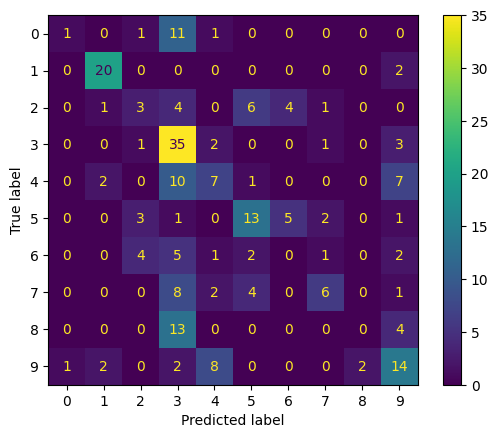

In [42]:
#cm1 = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, test_pred)
basicRFC_cm = metrics.ConfusionMatrixDisplay(confusion_matrix)
basicRFC_cm.plot()
plt.show()

In [43]:
print(confusion_matrix)

[[ 1  0  1 11  1  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  2]
 [ 0  1  3  4  0  6  4  1  0  0]
 [ 0  0  1 35  2  0  0  1  0  3]
 [ 0  2  0 10  7  1  0  0  0  7]
 [ 0  0  3  1  0 13  5  2  0  1]
 [ 0  0  4  5  1  2  0  1  0  2]
 [ 0  0  0  8  2  4  0  6  0  1]
 [ 0  0  0 13  0  0  0  0  0  4]
 [ 1  2  0  2  8  0  0  0  2 14]]


In [2]:
print(basicRFC_cm)

NameError: name 'basicRFC_cm' is not defined

### 3.2. Random forest - Advanced task

### 3.2.1 Edge Detection

In [274]:
# create a function to detect edges
#using sobel edge detector
# first denoise image using the Gaussian blur

def extract_features(data):
    feature_list = []
    for image in range(data.shape[0]):
        passed_image = data[image,:]
        img = passed_image
        
        #filter ( Gausssian blur)
        blur = cv2.GaussianBlur(img, (5,5),0)
        
        # sobel edge detection
        sobel_edge = sobel(blur)
        reshaped_sobel = sobel_edge.reshape(-1)
        feature_list.append(reshaped_sobel)
        
    return np.array(feature_list)

In [275]:
# Extract features from grayscale training data 
train_features = extract_features(X_trainGray)
test_features = extract_features(X_testGray)

X_trainGray.shape, X_testGray.shape


((243, 14400), (231, 14400))

In [276]:
# use extracted features to fit model
rfc.fit(train_features, y_train)

RandomForestClassifier(random_state=4)

In [277]:
test_pred2 = rfc.predict(test_features)

In [278]:
accuracy_score(y_test,test_pred2)

0.23376623376623376

In [265]:
#height =
width = 120
reshaped_train = train_features.reshape((trainFirst_dim, 120, 120))


In [266]:
reshaped_train.shape

(243, 120, 120)

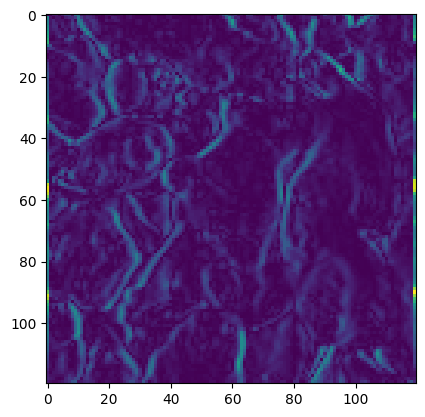

In [310]:
#reshaped_train = reshape(train_features)
plt.imshow(reshaped_train[56])

### grid saerch

In [312]:
param_grid = {
    'n_estimators': [100, 200, 300],                # Number of trees
    'criterion': ['gini', 'entropy']
    'max_depth': [None, 5, 10],                      # Maximum depth of trees
}

In [ ]:
grid_search = GridSearchCV(estimator=rfc,  verbose=3, param_grid=param_grid, cv=kfold_cv, scoring='accuracy')
grid_search.fit(X_trainGray, y_train)

In [316]:
grids_result = pd.DataFrame(grid_search.cv_results_)

In [318]:
grids_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.489349,0.105193,0.007126,0.001548,None,sqrt,1,2,100,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.448980,0.551020,0.265306,0.458333,0.395833,0.423895,0.093717,97
1,2.830454,0.141790,0.015999,0.000033,None,sqrt,1,2,200,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.489796,0.510204,0.265306,0.500000,0.500000,0.453061,0.094099,17
2,4.252387,0.243751,0.023450,0.001146,None,sqrt,1,2,300,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.469388,0.510204,0.265306,0.500000,0.479167,0.444813,0.090916,39
3,1.313953,0.058617,0.008820,0.003902,None,sqrt,1,5,100,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.489796,0.469388,0.306122,0.458333,0.395833,0.423895,0.066718,97
4,2.567132,0.026756,0.016007,0.000025,None,sqrt,1,5,200,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.530612,0.489796,0.306122,0.458333,0.395833,0.436139,0.078518,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.430880,0.006395,0.014423,0.003152,10,log2,4,5,200,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.428571,0.530612,0.326531,0.416667,0.458333,0.432143,0.066013,76
158,0.636197,0.006355,0.020836,0.003955,10,log2,4,5,300,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.448980,0.530612,0.346939,0.458333,0.437500,0.444473,0.058641,43
159,0.243340,0.022031,0.008001,0.000038,10,log2,4,10,100,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.489796,0.448980,0.346939,0.354167,0.395833,0.407143,0.055029,131
160,0.463603,0.028047,0.016096,0.000206,10,log2,4,10,200,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.428571,0.551020,0.326531,0.395833,0.416667,0.423724,0.072804,105


In [319]:
best_model = grid_search.best_estimator_

In [322]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [323]:
test_pred4 = best_model.predict(X_testGray)


In [324]:
accuracy = accuracy_score(y_test, test_pred4)

In [325]:
accuracy

0.42424242424242425

# 4. Task 2 - Multilayer Perceptron

## 4.1. Basic Implementation

### 4.1.1 Build and fit MLP model (basic_implementation)

In [330]:
neurons = (20,15,10)
mlp1 = snn.MLPClassifier(
    activation = 'logistic',
    hidden_layer_sizes = neurons,
    max_iter = 100,
    solver = 'adam',
    random_state = 9,
    early_stopping = True,
    validation_fraction = 0.2
)
    
mlp1.fit(X_trainGray, y_train)

MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(20, 15, 10), max_iter=100, random_state=9,
              validation_fraction=0.2)

In [ ]:
#model coefficients

mlp1.coefs_

In [333]:
# model predictions

mlp1_preds = mlp1.predict(X_testGray)


In [334]:
# accuracy score

accuracy_score(y_test, mlp1_preds)

0.09523809523809523

In [336]:
print(classification_report(y_test, mlp1_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.10      1.00      0.17        22
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        27
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        29

    accuracy                           0.10       231
   macro avg       0.01      0.10      0.02       231
weighted avg       0.01      0.10      0.02       231



C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

## Random Forest - Advanced task

### 4.2. Ensemble Learning using Voting Classifier

### 4.2.1 Build 3 other different models

#### Model 2

In [348]:
# model 1

neurons1 = (250,100,50)
mlp_model2 = snn.MLPClassifier(
    activation = 'relu',
    hidden_layer_sizes = neurons1,
    max_iter = 100,
    solver = 'sgd',
    random_state = 1,
    early_stopping = True,
    validation_fraction = 0.3
)
    
mlp_model2.fit(X_trainGray, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(250, 100, 50),
              max_iter=100, random_state=1, solver='sgd',
              validation_fraction=0.3)

In [349]:
# predict and accuracy

mlp_model2_preds = mlp_model2.predict(X_testGray)

accuracy_score(y_test, mlp_model2_preds)

0.09090909090909091

#### Model 3

In [359]:
neurons2 = (300,100,80,40)
mlp_model3 = snn.MLPClassifier(
    activation = 'logistic',
    hidden_layer_sizes = neurons2,
    max_iter = 100,
    solver = 'lbfgs',
    random_state = 5,
    early_stopping = True,
    validation_fraction = 0.3
)
    
mlp_model3.fit(X_trainGray, y_train)

MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(300, 100, 80, 40), max_iter=100,
              random_state=5, solver='lbfgs', validation_fraction=0.3)

In [360]:
mlp_model3_preds = mlp_model3.predict(X_testGray)

accuracy_score(y_test, mlp_model3_preds)

0.18181818181818182

### Model 4

In [357]:
neurons4 = (100,45,16)
mlp_model4 = snn.MLPClassifier(
    activation = 'relu',
    hidden_layer_sizes = neurons3,
    max_iter = 150,
    solver = 'lbfgs',
    random_state = 8,
    early_stopping = True,
    validation_fraction = 0.3
)
    
mlp_model4.fit(X_trainGray, y_train)

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 45, 16, 5),
              max_iter=150, random_state=8, solver='lbfgs',
              validation_fraction=0.3)

In [358]:
mlp_model4_preds = mlp_model4.predict(X_testGray)

accuracy_score(y_test, mlp_model4_preds)

0.3333333333333333

### Build Voting Classifier

In [380]:
# initialize voting classifier

ensemble_model = ensemble.VotingClassifier(estimators = [('0', mlp1), ('1', mlp_model2), ('2', mlp_model3), ('3', mlp_model4)])

In [381]:
# fit ensembled model
ensemble_model.fit(X_trainGray, y_train)

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


VotingClassifier(estimators=[('0',
                              MLPClassifier(activation='logistic',
                                            early_stopping=True,
                                            hidden_layer_sizes=(20, 15, 10),
                                            max_iter=100, random_state=9,
                                            validation_fraction=0.2)),
                             ('1',
                              MLPClassifier(early_stopping=True,
                                            hidden_layer_sizes=(250, 100, 50),
                                            max_iter=100, random_state=1,
                                            solver='sgd',
                                            validation_fraction=0.3)),
                             ('2',
                              MLPClassifier(activation='logistic',
                                            early_stopping=True,
                                            hidden_layer_sizes=(300, 100, 80,
                                                                40),
                                            max_iter=100, random_state=5,
                                            solver='lbfgs',
                                            validation_fraction=0.3)),
                             ('3',
                              MLPClassifier(early_stopping=True,
                                            hidden_layer_sizes=(100, 45, 16, 5),
                                            max_iter=150, random_state=8,
                                            solver='lbfgs',
                                            validation_fraction=0.3))])

In [382]:
ensemble_predictions = ensemble_model.predict(X_testGray)

In [383]:
accuracy = accuracy_score(y_test,ensemble_predictions)
accuracy

0.23376623376623376

## Task 3 - Convolutional Neural Networks

# Task 4 - Clustering

In [22]:
from sklearn.cluster import KMeans


In [93]:
num_clusters = 3

In [101]:
km = KMeans(num_clusters, init = 'kmeans++')

In [102]:
km_model = km.fit(X_trainGray)

InvalidParameterError: The 'init' parameter of KMeans must be a str among {'k-means++', 'random'}, a callable or an array-like. Got 'kmeans++' instead.

In [96]:
km_model.cluster_centers_.shape

(3, 40000)

In [97]:
km_pred = km.predict(X_trainGray)

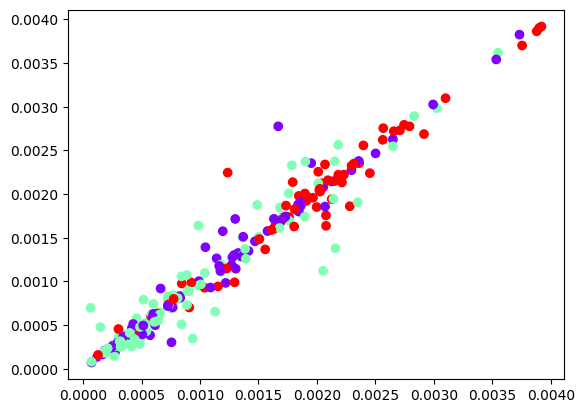

In [98]:
plt.scatter(X_trainGray[:, 0], X_trainGray[:,1], c= km_pred, cmap='rainbow')

In [99]:
accuracy_score(km_pred,y_train)

0.07818930041152264

In [38]:
pca = PCA(n_components= 0.85)

In [39]:
#X_trainGray  = pca.fit_transform(X_trainGray)
pca_train = pca.fit_transform(X_trainGray)
pca_test = pca.transform(X_testGray)


In [40]:
pca_test.shape

(231, 110)

In [41]:
X_testGray.shape

(231, 40000)

In [43]:
km2 = km.fit(pca_train)

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
km_pred2 = km2.predict(pca_test)

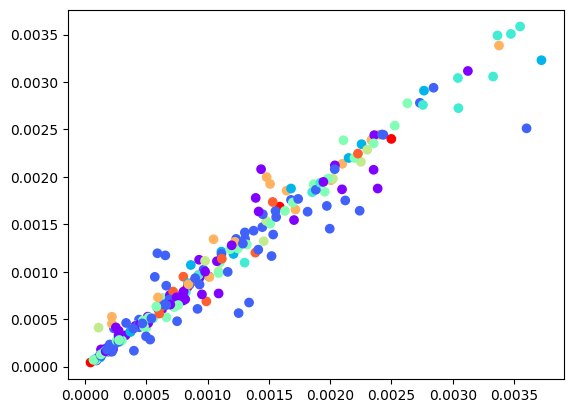

In [45]:
plt.scatter(X_testGray[:, 0], X_testGray[:,1], c= km_pred2, cmap='rainbow')

In [47]:
accuracy_score(km_pred2, y_test)

0.05194805194805195

In [48]:
from sklearn.metrics import silhouette_score

In [49]:
min_clusters = 2
max_clusters = 9

In [50]:
silhouette_scores = []

In [54]:
for K in range(min_clusters, max_clusters + 1):
    # Perform clustering using K-means
    k_means = KMeans(n_clusters=K, random_state=0)
    k_means.fit(X_trainGray)
    
    # Get the cluster assignments for each data point
    labels = k_means.labels_
    
    # Compute the Silhouette coefficient
    silhouette = silhouette_score(X_trainGray, y_train)
    
    # Append the Silhouette coefficient to the list
    silhouette_scores.append(silhouette)

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

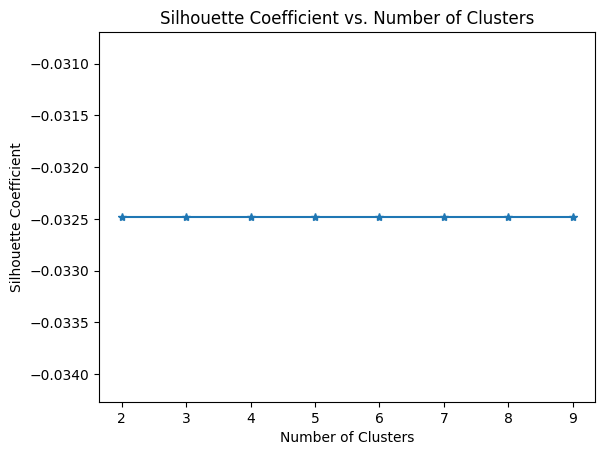

In [55]:
plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Number of Clusters')
plt.show()

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

Text(0, 0.5, 'WCSS')

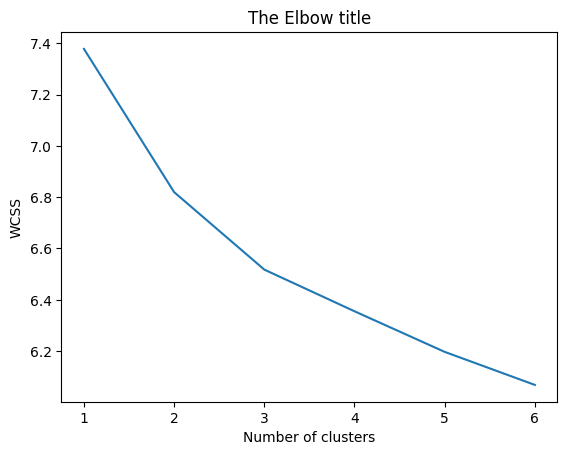

In [56]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(X_trainGray)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Isioma\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

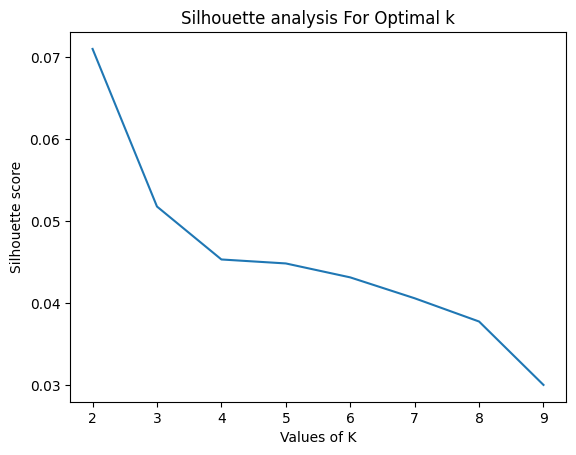

In [70]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_avg = []
for num_clusters in range_n_clusters:
    
    # initialise kmeans
    k_silhoutte = KMeans(n_clusters=num_clusters)
    k_silhoutte.fit(X_trainGray)
    cluster_labels = k_silhoutte.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(X_trainGray,cluster_labels ))


plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()